# 第14章 パラメータ推定への応用と拡張（EKBF）

In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

#### 乱数シードの指定（テキスト掲載用）
拙著に掲載の標本路を再現するため，シードを明示しておきます．本来は必要ないので，コメントアウトしてもいいです．

In [2]:
np.random.seed(123)

## 本章の共通設定

In [3]:
import Ch14_common as my
for line in open('Ch14_common.py'): print(line[:-1])

import numpy as np
import matplotlib.pyplot as plt

### デフォルト値
default_values = ( #Q, R, C, D, x0, dt, tn, p_list
    np.diag([0.0001,0.0001]), #Q:  システム雑音の共分散
    np.array([[0.0001]]),     #R:  観測雑音の共分散
    np.array([[1, 0]]),       #C:  変位のみ
    np.eye(2),                #D:  駆動行列
    np.array([0.0, 0.0]),     #x0: 初期値
    0.02,                     #dt: 時間ステップ
    2000,                     #tn: 時系列長
    [1, 0.2, 1],              #p_list: k, c, a
)

### 外部励振
def Forcing(t):
    return np.sin(1.5*t)

### 拡大系の導出
def get_extended_system(x0, Q, D, C, A=None, Qval=1.2):
        
    ex0 = np.append(x0, [0.0])
    # 拡大系
    if A is not None:
        eA = np.pad(A, (0,1), 'constant') #Aを1行1列拡大して0で埋める
        eA[-2,-1] = 1 #必要箇所に1を代入する
    else:
        eA = None
    # 推定パラメータにもシステム雑音を仮定（無いと推定パラメータが動かなくなる）
    eD = np.pad(D, (0,1), 'constant')
    eD[-1,-1] = 1
    # 推定パラメータは観測できないとする
    eC = np.pad(C, (0,1), 'constant')
    eC = np.delete(eC, axis=0, obj=-1)
    # 推定パラメータ用のシステム雑音強度を追加
    e

### 標本路の取得テスト

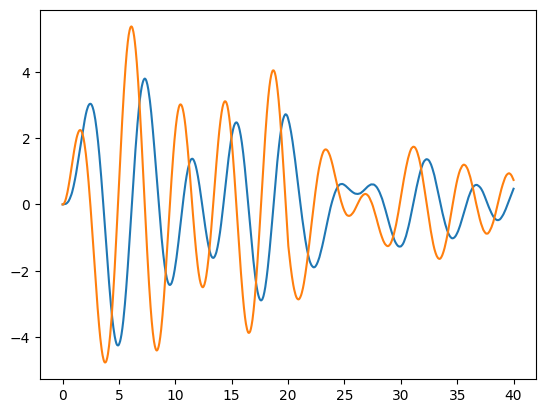

In [4]:
sim = my.model_1dof_tv(p_idx=2, p1=3, p2=1)
sim.get_sample_path()
plt.plot(sim.tt, sim.xx)

## 14.2 拡張カルマンフィルタ

### 算法14.2 (EKBF)

In [5]:
from class_EKBF import *
for line in open('class_EKBF.py'): print(line[:-1])

import numpy as np
from scipy.integrate import ode

class class_EKBF: #拡張Kalman-Bucyフィルタ(Extended Kalman-Bucy filter)

    def __init__(s, xdim, ydim, D, Q, R, x0, cov0=None, t0=0.0):
        
        s.xdim = xdim #状態ベクトルの次元
        s.ydim = ydim #出力ベクトルの次元

        ### システム行列
        ### 状態行列 s.A は推定時に代入される
        ### 観測行列 s.C は推定時に代入される
        s.D = np.array(D) #駆動行列
        # 雑音
        s.Q = np.array(Q) #システム雑音の共分散
        s.R = np.array(R) #観測雑音の共分散
        
        ### 共分散行列のベクトル化の次元
        s.covdim = s.xdim**2 #本来は三角成分だけでよいが手抜き

        ### フィルタの初期値
        s.t    = t0           #初期時刻
        s.xf   = np.array(x0) #濾波推定値
        s.K    = None         #カルマンゲイン
        #共分散行列とその初期値
        if cov0 is not None:
            s.cov = np.array(cov0)
        else:
            s.cov = np.zeros((s.xdim,s.xdim))

        #期待値と共分散行列を1列に並べた状態ベクトル
        X0 = s.xcov2vec(s.xf, s.cov)

        ### 常微分方程式のソルバー
        s.solver = ode(s.ode_func).set_integrator('dopri5')
        s.solver.set_

### 数値例作成用のクラス

In [6]:
import matplotlib.gridspec as gsp
import time

class EKBF_param(class_EKBF):
    
    def __init__(s, x0, cov0, Qval):

        Q, R, C, D, _x0, dt, tn, p_list = my.default_values
        _x0, Q, D, C = my.get_extended_system(_x0, Q, D, C, Qval=Qval)
        
        x0   = np.array(x0)   #初期状態
        cov0 = np.diag(cov0)  #初期誤差共分散
        xdim = len(x0);       #状態ベクトルの次元
        ydim = C.shape[0];    #出力ベクトルの次元
        super().__init__(xdim, ydim, D, Q, R, x0, cov0)

        s.dt = dt             #時間ステップ
        s.C = C
        s.p_list = p_list.copy()
                          
        s.k, s.c, s.a = s.p_list
            
    def C_func(s, x, t):
        return s.C.dot(x)

    def C_jac(s, x, t):
        return s.C
    
    def get_example(s, p_idx, p1, p2):
        target = my.model_1dof_tv(p_idx, p1, p2)
        target.get_sample_path()
        s.tt = target.tt
        s.xx = target.xx
        s.param = target.param
        s.xxf = np.zeros((len(target.tt),3))
        s.pp = np.zeros(len(target.tt))
        
        start = time.time()
        for i, y in enumerate(target.yy):
            s.xxf[i] = s.xf
            s.filtering(y,s.dt,t=s.tt[i])
#            s.filtering(y,s.dt)
        elapsed_time = time.time() - start
        
        #s.stability() #参考程度
        
        return elapsed_time

    def plot(s):
        fig = plt.figure(figsize=(5, 4))
        gs = gsp.GridSpec(2,2)
        ax1 = fig.add_subplot(gs[0,:])
        ax2 = fig.add_subplot(gs[1,0])
        ax3 = fig.add_subplot(gs[1,1])
    
        ax1.plot(s.tt, s.xxf[:,2], label='filtered'); ax1.grid()
        ax2.plot(s.xxf[:,0], s.xxf[:,1], label='filtered')
        ax2.plot(s.xx[:,0], s.xx[:,1], label='original')
        ax2.legend()
        plt.tight_layout()

In [7]:
Elapsed_Times = []

### 線形と同じaの同定

In [8]:
class EKBF_a(EKBF_param):
    
    def __init__(s, x0, cov0, Qval):
        super().__init__(x0, cov0, Qval)

    def A_func(s, x, t):
        ff = np.array([
            x[1],
            - s.k*x[0] - s.c*x[1] + x[2]*my.Forcing(t),
            0
        ])

        return ff

    #ヤコビ行列にxの成分がない．すなわち，時変なだけで非線形ではない．
    #EKFのコードを流用してるだけで，普通の時変カルマンフィルタを解いてるのと同じ．
    def A_jac(s, x, t): 
        ff_jac = np.array([
            [0,       1, 0],
            [-s.k, -s.c, my.Forcing(t)],
            [0,       0, 0]
        ])

        return ff_jac

    
np.random.seed(123)
ekbf_a = EKBF_a( x0=[0,0,0], cov0=[0.0001,0.0001,0.01], Qval=0.002 )
etim = ekbf_a.get_example(p_idx=2, p1=3, p2=1)
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.002 ]]


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.97474594e-04 -1.97095806e-06  9.78349560e-09]
 [ 8.65434371e-05 -4.82374598e-06 -7.25464355e-08]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


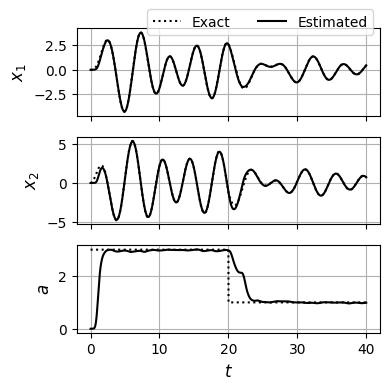

In [9]:
print(ekbf_a.xxf[:3,:])
my.plot(ekbf_a,'$a$')
my.save('figs/Ch14-EKBF-a.eps')

### 線形では解けないkの同定

In [10]:
class EKBF_k(EKBF_param):
    
    def __init__(s, x0, cov0, Qval):
        super().__init__(x0, cov0, Qval)
    
    def A_func(s, x, t):
        ff = np.array([
            x[1],
            - (x[2])*x[0] - s.c*x[1] + s.a*my.Forcing(t),
            0
        ])

        return ff
    
    def A_jac(s, x, t):
        ff_jac = np.array([
            [0,        1,     0],
            [-x[2], -s.c, -x[0]],
            [0,        0,     0]
        ])

        return ff_jac

np.random.seed(123)
ekbf_k = EKBF_k( x0=[0,0,0], cov0=[0.0001,0.0001,0.015], Qval=0.0005)
etim = ekbf_k.get_example(p_idx=0, p1=0.5, p2=1) #kを変化させる
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.0005]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


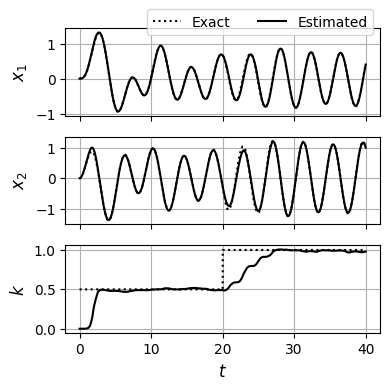

In [11]:
my.plot(ekbf_k,'$k$')
my.save('figs/Ch14-EKBF-k.eps')

### 線形では解けないｃの同定

In [12]:
class EKBF_c(EKBF_param):
    
    def __init__(s, x0, cov0, Qval):
        super().__init__(x0, cov0, Qval)
        
    def A_func(s, x, t):
        ff = np.array([
            x[1],
            - s.k*x[0] - (x[2])*x[1] + s.a*my.Forcing(t),
            0
        ])

        return ff

    def A_jac(s, x, t):
        ff_jac = np.array([
            [0,        1,     0],
            [-s.k, -x[2], -x[1]],
            [0,        0,     0]
        ])

        return ff_jac

np.random.seed(123)
ekbf_c = EKBF_c( x0=[0,0,0], cov0=[0.001,0.001,0.005], Qval=0.0007 ) 
etim = ekbf_c.get_example(p_idx=1, p1=0.5, p2=1.0) #cを変化させる
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.0007]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


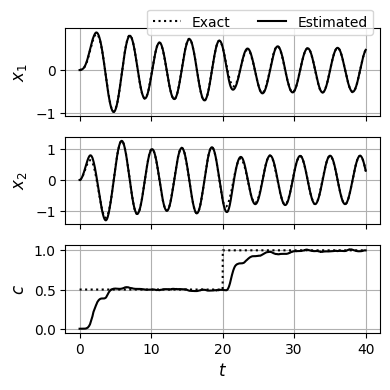

In [13]:
my.plot(ekbf_c,'$c$')
my.save('figs/Ch14-EKBF-c.eps')

In [14]:
print(Elapsed_Times)

[4.465799808502197, 4.201047420501709, 3.8553733825683594]
